In [1]:
import lecilab_behavior_analysis.utils as utils
import lecilab_behavior_analysis.df_transforms as dft
import lecilab_behavior_analysis.plots as plots
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import time
import datetime


%load_ext autoreload
%autoreload 2

In [2]:
project = "visual_and_COT_data"
animals=['ACV001', 'ACV002', 'ACV003', 'ACV004', 'ACV005', 'ACV006', 'ACV007', 'ACV008', 'ACV009', 'ACV010']
df_list = []
for mouse in animals:
    local_path = Path(utils.get_outpath()) / Path(project) / Path("sessions") / Path(mouse)
    df = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")
    df_list.append(df)
    print(f"Loaded data for {mouse}.")
# concatenate the dataframes
df = pd.concat(df_list, ignore_index=True)
clear_output(wait=True)
time.sleep(.5)
print("Data read successfully.")

Data read successfully.


In [13]:
# restrict analysis to multisensory sessions, only auditory
df_me_a = df[np.logical_and(
    df["current_training_stage"] == "TwoAFC_multisensory_easy",
    df["stimulus_modality"] == "auditory"
)]

In [14]:
df_me_a = dft.analyze_df(df_me_a)

<Axes: xlabel='Correct side', ylabel='Number of trials'>

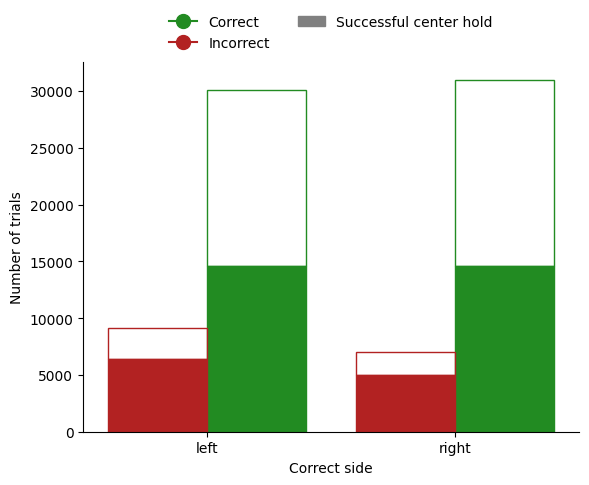

In [15]:
plots.number_of_correct_responses_plot(df_me_a)

Question 1. Do they poke on the side ports after breaking fixation?

1.1 How long do they take to poke back in center after breaking fixation?

1.2 Does this differ between correct and incorrect trials?

1.3 Is this usually the correct port?

1.4. Do they change their mind at some point?

In [54]:
# 1.2. An incorrect hold shows as a sequence: 'Port2In', 'Tup', 'Port2Out' , or 'Port2In', 'Port2Out'
# (a correct one is 'Port2In', 'Tup', 'Tup', 'Port2Out')
# get the next event after this sequence

def detect_incorrect_hold_and_next_event(events):
    incorrect_hold_sequence_one = ['Port2In', 'Tup', 'Port2Out']
    incorrect_hold_sequence_two = ['Port2In', 'Port2Out']
    correct_hold_sequence = ['Port2In', 'Tup', 'Tup', 'Port2Out']
    next_events = []
    events = eval(events)
    # remove all events after a correct hold
    for i in range(len(events) - 3):
        if events[i:i+4] == correct_hold_sequence:
            events = events[:i+4]
            break
    for i in range(len(events) - 2):
        if events[i:i+3] == incorrect_hold_sequence_one:
            if i + 3 < len(events):
                next_events.append(events[i + 3])
        elif events[i:i+2] == incorrect_hold_sequence_two:
            if i + 2 < len(events):
                next_events.append(events[i + 2])
    return next_events

In [55]:
df_me_a["next_event_after_fixation_break"] = df_me_a["ordered_list_of_events"].apply(detect_incorrect_hold_and_next_event)

In [56]:
df_me_a.head()

,session,date,trial,subject,task,system_name,run_mode,Port1In,Port1Out,Port2In,...,year_month_day,miss_trial,first_choice,last_choice,early_pokeout,total_trial,trial_of_day,next_event_after_fixation_break,next_event_after_fixation_break_classified,port2_holds
72240,397.0,2025-07-05 11:25:32,1.0,ACV001,TwoAFC,village01,Auto,"[1751711161.183074, 1751711163.322774]","[1751711161.301174, 1751711163.516074]","[1751711161.656874, 1751711162.564674, 1751711...",...,2025-07-05,False,right,right,True,1.0,1.0,"[Port3In, Port1In]","[correct_side, incorrect_side]","[0.1761000156402588, 0.44099998474121094, 0.51..."
72250,399.0,2025-07-05 13:11:57,1.0,ACV001,TwoAFC,village01,Auto,"[1751717543.682024, 1751717546.021324]",[1751717543.880524],"[1751717540.126124, 1751717541.814224, 1751717...",...,2025-07-05,False,left,left,True,2.0,1.0,"[Port3In, Port3In, Port1In, Port3In]","[incorrect_side, incorrect_side, correct_side,...","[0.12820005416870117, 0.3733999729156494, 0.37..."
72251,399.0,2025-07-05 13:11:57,2.0,ACV001,TwoAFC,village01,Auto,[1751717549.67401],"[1751717547.60321, 1751717550.00371]","[1751717547.89781, 1751717548.93931, 175171755...",...,2025-07-05,False,right,right,True,3.0,2.0,"[Port3In, Port1In]","[incorrect_side, correct_side]","[0.4112999439239502, 0.43959999084472656, 0.52..."
72252,399.0,2025-07-05 13:11:57,3.0,ACV001,TwoAFC,village01,Auto,"[1751717553.346215, 1751717554.580415, 1751717...","[1751717553.6379151, 1751717554.8091152]","[1751717553.842015, 1751717555.011315]",...,2025-07-05,False,left,left,True,4.0,3.0,[Port1In],[correct_side],"[0.4632999897003174, 0.5769000053405762]"
72253,399.0,2025-07-05 13:11:57,4.0,ACV001,TwoAFC,village01,Auto,"[1751717558.421546, 1751717559.629846]","[1751717557.410646, 1751717558.609046, 1751717...","[1751717557.665746, 1751717558.8161461, 175171...",...,2025-07-05,False,left,left,False,5.0,4.0,[],[],"[0.5397000312805176, 0.5320999622344971, nan]"


In [57]:
# transform the next_event_after_fixation_break column to a more usable format: 'correct_side', 'incorrect_side', 'center'
def classify_next_events(next_events, correct_side):
    classifications = []
    for event in next_events:
        if event == 'Port1In':
            if correct_side == 'left':
                classifications.append('correct_side')
            else:
                classifications.append('incorrect_side')
        elif event == 'Port3In':
            if correct_side == 'right':
                classifications.append('correct_side')
            else:
                classifications.append('incorrect_side')
        elif event == 'Port2In':
            classifications.append('center')
        else:
            pass  # ignore other events
    return classifications

In [58]:
df_me_a["next_event_after_fixation_break_classified"] = df_me_a.apply(
    lambda row: classify_next_events(row["next_event_after_fixation_break"], row["correct_side"]), axis=1
)

In [59]:
# count occurrences of each classification in total
all_classifications_correct = []
all_classifications_incorrect = []
for classifications, correct in zip(df_me_a["next_event_after_fixation_break_classified"], df_me_a["correct"]):
    if correct:
        all_classifications_correct.extend(classifications)
    else:
        all_classifications_incorrect.extend(classifications)
classification_counts_correct = pd.Series(all_classifications_correct).value_counts()
classification_counts_incorrect = pd.Series(all_classifications_incorrect).value_counts()
print("Correct trials:")
print(classification_counts_correct)
print("Incorrect trials:")
print(classification_counts_incorrect)

Correct trials:
correct_side      66209
center            26011
incorrect_side     4161
Name: count, dtype: int64
Incorrect trials:
center            12666
correct_side       3679
incorrect_side     3290
Name: count, dtype: int64


<Axes: >

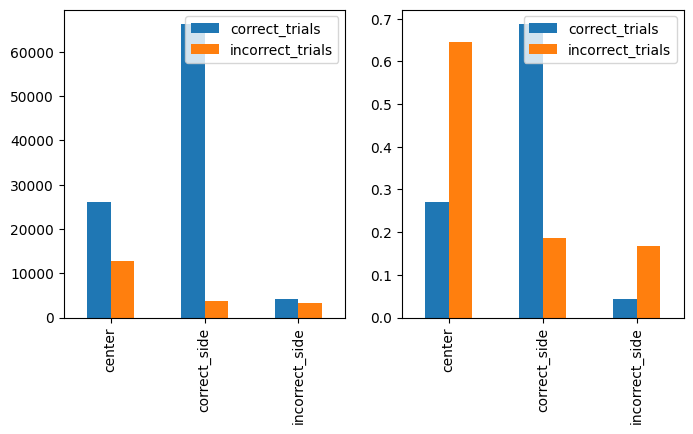

In [60]:
# merge the two series into a dataframe for easier plotting
classification_df = pd.DataFrame({
    'correct_trials': classification_counts_correct,
    'incorrect_trials': classification_counts_incorrect
}).fillna(0)
# transform to proportions
classification_df_prop = classification_df.div(classification_df.sum(axis=0), axis=1)
# make bar plots, side by side
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
classification_df_prop.plot.bar(ax=axs[1])
classification_df.plot.bar(ax=axs[0])

the 20% correct side pokes that end up being incorrect trials is interesting

(array([11345.,  2462.,   998.,   499.,   279.,   158.,    95.,    89.,
           52.,    45.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

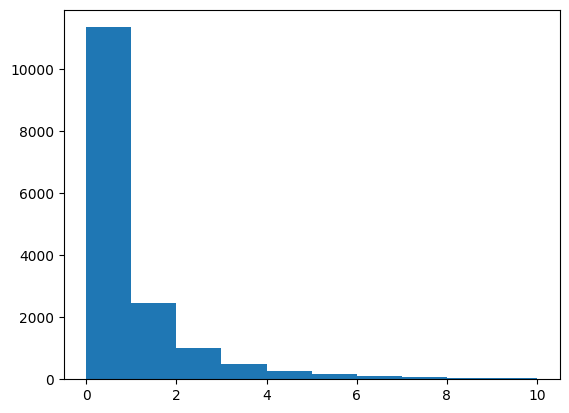

In [69]:
# how many of the incorrect trials have at least one correct side poke after breaking fixation?
# first, how many fixation breaks are there in incorrect trials?
plt.hist(df_me_a[df_me_a["correct"] == False]["next_event_after_fixation_break_classified"].apply(len), bins=range(0, 11))


In [64]:
df_me_a[df_me_a["correct"] == False]["next_event_after_fixation_break_classified"].apply(len)

72251      2
72253      0
72259      2
72262      7
72264      3
          ..
1228978    0
1228980    0
1228989    3
1229078    0
1229099    0
Name: next_event_after_fixation_break_classified, Length: 16120, dtype: int64

In [ ]:
# how long do these fixation take and is this related with the kind of poke they do after?
df_me_a["port2_holds"] = df_me_a.apply(lambda row: utils.get_trial_port_hold(row, 2), axis=1)

In [53]:
df_me_a.head()

,session,date,trial,subject,task,system_name,run_mode,Port1In,Port1Out,Port2In,...,year_month_day,miss_trial,first_choice,last_choice,early_pokeout,total_trial,trial_of_day,next_event_after_fixation_break,next_event_after_fixation_break_classified,port2_holds
72240,397.0,2025-07-05 11:25:32,1.0,ACV001,TwoAFC,village01,Auto,"[1751711161.183074, 1751711163.322774]","[1751711161.301174, 1751711163.516074]","[1751711161.656874, 1751711162.564674, 1751711...",...,2025-07-05,False,right,right,True,1.0,1.0,"[Port3In, Port1In, Tup]","[correct_side, incorrect_side]","[0.1761000156402588, 0.44099998474121094, 0.51..."
72250,399.0,2025-07-05 13:11:57,1.0,ACV001,TwoAFC,village01,Auto,"[1751717543.682024, 1751717546.021324]",[1751717543.880524],"[1751717540.126124, 1751717541.814224, 1751717...",...,2025-07-05,False,left,left,True,2.0,1.0,"[Port3In, Port3In, Port1In, Port3In]","[incorrect_side, incorrect_side, correct_side,...","[0.12820005416870117, 0.3733999729156494, 0.37..."
72251,399.0,2025-07-05 13:11:57,2.0,ACV001,TwoAFC,village01,Auto,[1751717549.67401],"[1751717547.60321, 1751717550.00371]","[1751717547.89781, 1751717548.93931, 175171755...",...,2025-07-05,False,right,right,True,3.0,2.0,"[Port3In, Port1In, Tup]","[incorrect_side, correct_side]","[0.4112999439239502, 0.43959999084472656, 0.52..."
72252,399.0,2025-07-05 13:11:57,3.0,ACV001,TwoAFC,village01,Auto,"[1751717553.346215, 1751717554.580415, 1751717...","[1751717553.6379151, 1751717554.8091152]","[1751717553.842015, 1751717555.011315]",...,2025-07-05,False,left,left,True,4.0,3.0,[Port1In],[correct_side],"[0.4632999897003174, 0.5769000053405762]"
72253,399.0,2025-07-05 13:11:57,4.0,ACV001,TwoAFC,village01,Auto,"[1751717558.421546, 1751717559.629846]","[1751717557.410646, 1751717558.609046, 1751717...","[1751717557.665746, 1751717558.8161461, 175171...",...,2025-07-05,False,left,left,False,5.0,4.0,[Tup],[],"[0.5397000312805176, 0.5320999622344971, nan]"
